
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Gradient Attribution (Activations)


In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, functools
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, gradient, localizing

## Model

In [2]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cpu")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']
setting no_grad on ['embed', 'pos_embed', 'unembed']


### Load Data

In [3]:
## mem and non-mem set
#(mem_prompts, mem_counts),(non_mem_prompts,non_mem_counts) = dataLoaders.load_pile_splits("acc/gpt-neo-125M", as_torch=True)
#train_dl, test_dl = dataLoaders.train_test_batching(mem_prompts, non_mem_prompts, mem_batch=5, non_mem_batch=5, test_frac=0.0, set_twice=None)
#c_toks_NI, k_toks_NI = next(iter(train_dl))

## load perturbed mem set and original mem set
mem_prompts, non_mem_prompts = dataLoaders.load_perturbed_mem(file_path="acc/gpt-neo-125M")
train_dl = torch.utils.data.DataLoader(list(zip(mem_prompts, non_mem_prompts)), batch_size=10, shuffle=False)
c_toks_NI, k_toks_NI = next(iter(train_dl))

#c_toks_NI, k_toks_NI = c_toks_NI[0,:], k_toks_NI[0,:]

### Multiple Batches

In [4]:
c_types= ["k", "q", "v", "mlp_in", "mlp_out"] 
metric_fn = functools.partial(gradient.contrast_metric, I_range=[50,100], pool={"c":[-1],"k":[0,-1]}, norm_sets=5.0)
fwd_bwd_fn = functools.partial(gradient.run_fwd_bwd, optim_step=False, grad_norm=None)
c_type_gradsum = gradient.batched_fwd_bwd(model, train_dl, metric_fn, fwd_bwd_fn, n_batches=1, c_types=c_types)

0it [00:00, ?it/s]

pooling c_nll torch.Size([10, 49]), k_nll torch.Size([10, 49]) pool: {'c': [-1], 'k': [0, -1]}
contrast loss: -1.9103126525878906, c_nll: 2.3878908157348633, k_nll: 0.4775781035423279


0it [00:08, ?it/s]

returning ['blocks.0.attn.hook_k', 'blocks.1.attn.hook_k']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.attn.hook_q', 'blocks.1.attn.hook_q']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.attn.hook_v', 'blocks.1.attn.hook_v']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.hook_mlp_in', 'blocks.1.hook_mlp_in']... of shape: torch.Size([10, 12, 100, 768])
returning ['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out']... of shape: torch.Size([10, 12, 100, 768])


### Individual Sequences

In [5]:
fwd_bwd = functools.partial(gradient.contrast_metric,I_range=[50,100],pool={"c":[0],"k":[0]},norm_sets=1.0,only_set="c")
fwd_cache, bwd_cache, topk_idcs = gradient.run_fwd_bwd(model, fwd_bwd, c_toks_NI.squeeze(0), k_toks_NI.squeeze(0))

pooling c_nll torch.Size([10, 49]), k_nll torch.Size([10, 49]) pool: {'c': [0], 'k': [0]}


In [6]:
c_type = "v"
vals = c_type_gradsum[c_type]
#vals, _ = localizing.collect_c_type(model=model, cache=bwd_cache, c_type=c_type)
print(vals.shape)
vals =vals.mean(0)[...,-1,:]
vals = torch.max(vals,dim=-1)[0]
#vals = vals.mean(-1)[...,10] ## "k", "q", "v"

print(f"{vals.shape}")

torch.Size([10, 12, 100, 12, 64])
torch.Size([12, 100])


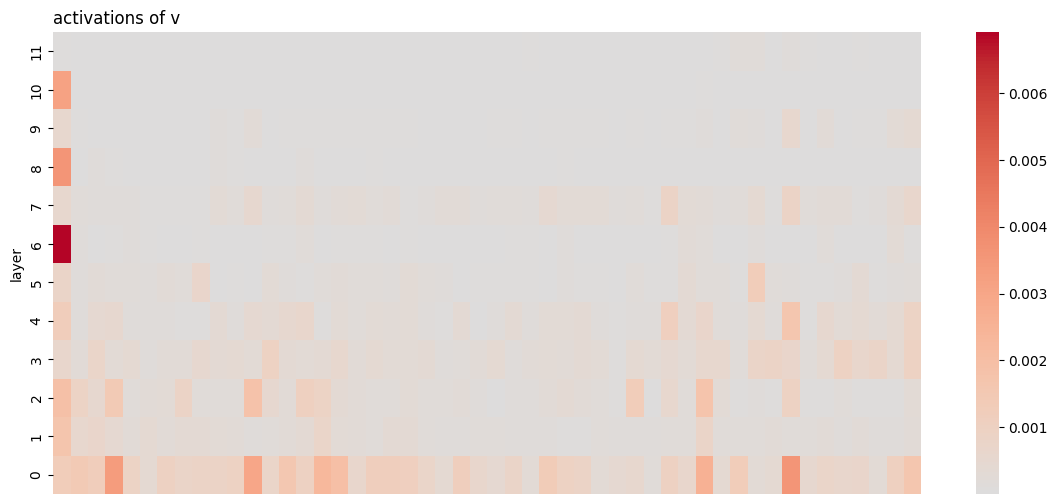

In [7]:
def plot_heatmap(vals:list, x_labels:list=None, y_labels:list=None, c_type:str=""):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
    fontsize = 12
    ax = sns.heatmap(vals,
                  cmap=mpl.colormaps["coolwarm"], center=0,
                  xticklabels=x_labels,
                  yticklabels=y_labels, square=False)
    ax.invert_yaxis()
    ax.set_ylabel("layer")
    ax.set_title(f"activations of {c_type}", fontsize=fontsize, loc="left")

layers = np.arange(0,vals.shape[0])
plot_heatmap(vals[...,:50], x_labels=[],y_labels=layers, c_type=c_type)
#plot_heatmap(vals[...,:50], x_labels=model.tokenizer.convert_ids_to_tokens(c_toks_NI[0,...,:50]),y_labels=layers)
#plot_heatmap(vals_norm[...,:], x_labels=model.tokenizer.convert_ids_to_tokens(c_toks_NI[0,...,:]),y_labels=c_names)

## Compare Change and Keep Set

In [8]:
c_types= ["k", "q", "v", "mlp_in", "mlp_out"] 
c_metric = functools.partial(gradient.contrast_metric, I_range=[50,100], pool={"c":[],"k":[]},norm_sets=1.0,only_set="c")
k_metric = functools.partial(gradient.contrast_metric, I_range=[50,100], pool={"c":[],"k":[]},norm_sets=1.0,only_set="k")

fwd_bwd = functools.partial(gradient.run_fwd_bwd, optim_step=False, grad_norm=None)

c_type_gradsum = gradient.batched_fwd_bwd(model, train_dl, metric_fn=c_metric, fwd_bwd_fn=fwd_bwd, n_batches=1, c_types=c_types)
k_type_gradsum = gradient.batched_fwd_bwd(model, train_dl, metric_fn=k_metric, fwd_bwd_fn=fwd_bwd, n_batches=1, c_types=c_types)

0it [00:00, ?it/s]

pooling c_nll torch.Size([10, 49]), k_nll torch.Size([10, 49]) pool: {'c': [], 'k': []}


0it [00:04, ?it/s]


returning ['blocks.0.attn.hook_k', 'blocks.1.attn.hook_k']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.attn.hook_q', 'blocks.1.attn.hook_q']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.attn.hook_v', 'blocks.1.attn.hook_v']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.hook_mlp_in', 'blocks.1.hook_mlp_in']... of shape: torch.Size([10, 12, 100, 768])
returning ['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out']... of shape: torch.Size([10, 12, 100, 768])


0it [00:00, ?it/s]

pooling c_nll torch.Size([10, 49]), k_nll torch.Size([10, 49]) pool: {'c': [], 'k': []}


0it [00:05, ?it/s]

returning ['blocks.0.attn.hook_k', 'blocks.1.attn.hook_k']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.attn.hook_q', 'blocks.1.attn.hook_q']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.attn.hook_v', 'blocks.1.attn.hook_v']... of shape: torch.Size([10, 12, 100, 12, 64])
returning ['blocks.0.hook_mlp_in', 'blocks.1.hook_mlp_in']... of shape: torch.Size([10, 12, 100, 768])
returning ['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out']... of shape: torch.Size([10, 12, 100, 768])


In [11]:
pool, topP = "mean", 0.001
c_grads, c_types = localizing.pool_c_activs(c_type_gradsum,pool=pool,topP=topP)
k_grads, c_types = localizing.pool_c_activs(k_type_gradsum,pool=pool,topP=topP)

c_grads, k_grads = torch.cumsum(c_grads, dim=1), torch.cumsum(k_grads, dim=1)

Text(0.2, -0.6, 'keep set')

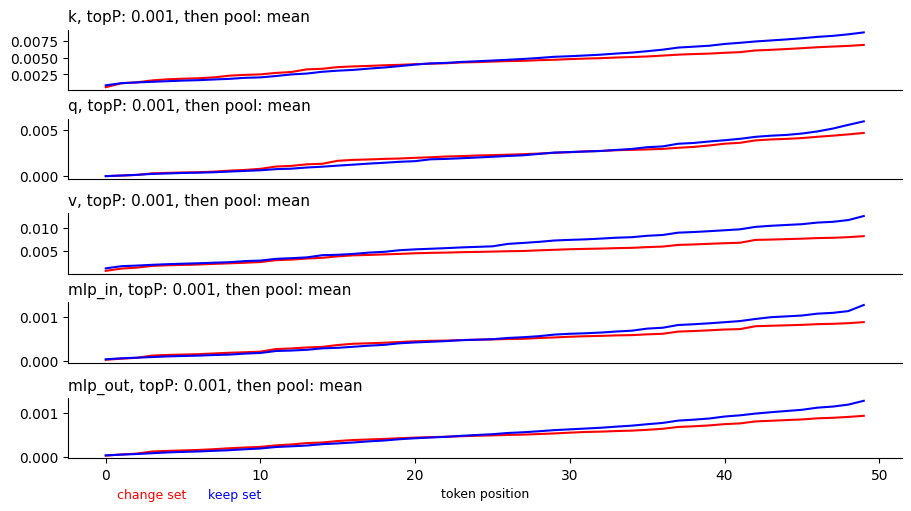

In [13]:
#def reshape_cumsum(grads): ## N, L, I, (H), D
#    grads = grads.mean(0).mean(0).detach()
#    grads = grads.view(grads.shape[0], -1)
#    grads = grads.mean(-1) ## sum all grads per token position
#    grads = torch.cumsum(grads, dim=0) ## sum from left to right
#    return grads[:50]

fontsize = 9
torch.set_printoptions(precision=2)
fig, axs = plt.subplots(len(c_type_gradsum.keys()), 1, figsize=(9, 5), gridspec_kw={'wspace': 0.6}, constrained_layout=True)

c_label_collect, k_label_collect = [], []

for i, c_type in enumerate(c_types):
    c_grad, k_grad = c_grads[i,0:50], k_grads[i,0:50]  ## N, L, I, (H), D
    
    #c_color, k_color = c_cmap(norm(i)), k_cmap(norm(i))
    c_color, k_color ="red", "blue" 
    #c sum: {c_grad.sum()}, k sum: {k_grad.sum()}
    axs[i].set_title(f"{c_type}, topP: {topP}, then pool: {pool}", loc="left", fontsize=fontsize+2)

    c_label, = axs[i].plot(np.arange(0, len(c_grad)), c_grad.numpy(), c=c_color, label=c_type)
    k_label, = axs[i].plot(np.arange(0, len(k_grad)), k_grad.numpy(), c=k_color, label=c_type)
    c_label_collect.append(c_label)
    
    if i < len(c_types)-1:
        axs[i].get_xaxis().set_ticks([])
    
axs[-1].set_xlabel(f"token position", fontsize=fontsize)
axs[-1].text(0.1, -0.6, 'change set', fontsize=fontsize, color=c_color, ha='center', va='center', transform=plt.gca().transAxes)
axs[-1].text(0.2, -0.6, 'keep set', fontsize=fontsize, color=k_color, ha='center', va='center', transform=plt.gca().transAxes)
